# UCDMCMC Tutorial

## Author
Adam Burgasser

## Version date
5 July 2024

## Summary
This tutorial aims to demonstrate some of the key tools provided in the UCDMCMC package

## Learning Goals
* Examining the provided model sets
* Configuring spectral data
* Conducting a grid fit of spectral data to models
* Conducting an MCMC fit of spectral data to models
* Generating new model sets (requires RAW models in SPLAT)

## Required packages
* ucdmcmc
* splat
* astropy
* matplotlib
* numpy

## Keywords
spectral analysis, ultracool dwarfs

## Companion Content
None


In [1]:
# import statements
import ucdmcmc
import splat
import numpy
from astropy.utils.data import download_file
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import copy
%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
You are currently using version 2024.07.05

If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




Welcome to the UCDMCMC spectral fitting code!
You are currently using version 8 July 2024

Currently running in error checking mode
Generate wavelength grid from 0.9 micron to 2.45 micron at constant resolution 300


## Model sets
``ucdmcmc`` currently comes equipped with 9 sets of models interpolated onto wavelegnth scales for the IRTF/SpeX (prism model) and JWST NIRSPEC (prism mode) instruments, and a generic "NIR" constant resolution model:

* atmos: [Phillips et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P)
* atmospp: [Meisner et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....166...57M)
* btdusty16: [Allard et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012RSPTA.370.2765A)
* btsettl08: [Allard et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012RSPTA.370.2765A)
* burrow06: [Burrows et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...640.1063B)
* dback24: Sonora diamondback, [Morley et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240200758M)
* elfowl24: Sonora elfowl, [Mukherjee et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...963...73M)
* karalidi: Sonora cholla, [Karalidi et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...923..269K)
* lacy23: [Lacy & Burrows(2023)](https://ui.adsabs.harvard.edu/abs/2023ApJ...950....8L)
* lowz: [Meisner et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...915..120M)
* sand24: [Alvarado et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024RNAAS...8..134A)
* sonora21: Sonora bobcat, [Marley et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...920...85M)

The models can be accessed with the ``getModelSet()`` function.

It is also possible to generate a set of new set of models if an existing "raw" set has been provided; these can be created using the ``createModelSet()`` function.


In [ ]:
ucdmcmc.modelInfo()

In [ ]:
# see what model sets have been computed alreeady
ucdmcmc.getModelSet(info=True)

In [ ]:
# getModelSet reads in both the models and wavelength grid
models,wave = ucdmcmc.getModelSet('sand24','JWST-NIRSPEC-PRISM')
models[:10]

In [ ]:
# select one of the models and plot it
par = dict(models.iloc[0])
mdl = ucdmcmc.getGridModel(models,par,wave)
mdl.plot()
mdl.info()

## Preparing spectral data

``ucdmcmc`` and ``splat`` have functions to prepare the observed spectrum before fitting to the models:

* ``resample()`` resamples the specrtum to the provided wavelength grid
* ``trim()`` is a SPLAT spectrum function that narrows the spectrum to a specific wavelength range
* ``fluxCalibrate()`` is a SPLAT spectrum function that flux calibrates the spectrum to a given magnitude
* ``maskWave()`` is a SPLAT spectrum function that allows you to mask out sections of the spectrum (e.g., telluric regions)


In [ ]:
# read in spectrum from SPLAT - a random T5
sp = splat.getSpectrum(lucky=True, spt='T5')[0]
sp.info()

# map spectrum to a particular wavelength grid and plot
wave = ucdmcmc.readWave('SPEX-PRISM')
spsm = ucdmcmc.resample(sp,wave)

# examine the output
plt.plot(sp.wave,sp.flux,'m-',lw=5,alpha=0.5)
plt.plot(spsm.wave,spsm.flux,'k-')



returning 1 file


SPEX-PRISM spectrum of 2MASS J05591914-1404488
Airmass = nan
Source designation = J05591914-1404488
Median S/N = 45
SpeX Classification = T4.0
Spectrum key = 10166, Source key = 10459

If you use these data, please cite:
	Burgasser, A. J. et al. (2006, Astrophysical Journal, 637, 1067-1093)
	bibcode: 2006ApJ...637.1067B

History:
	SPEX-PRISM spectrum successfully loaded
Reading in wavelength array for SPEX-PRISM instrument


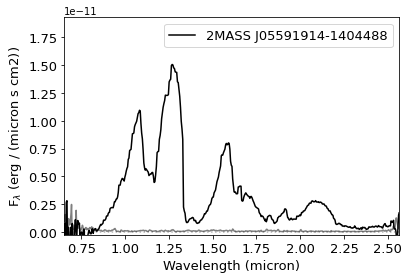

[<Figure size 432x288 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

In [14]:
# you can use SPLAT functions to scale the spectra
sp = splat.getSpectrum(shortname='J0559-1404')[0]
sp.info()

# scale to absolute J magnitude
mj = 13.78 # absolute 2MASS J of this source
sp.fluxCalibrate('2MASS J',mj,absolute=True)

# map spectrum to a particular wavelength grid and plot
wave = ucdmcmc.readWave('SPEX-PRISM')
spsm = ucdmcmc.resample(sp,wave)

spsm.plot()

You can trim noisy sections from the original spectrum, then resample to model grid


returning 1 lucky file



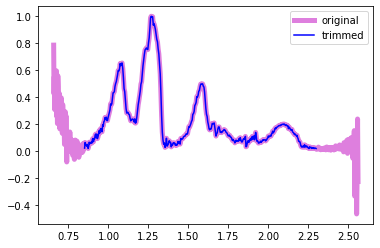

In [11]:
# trim noisy sections off of the original spectrum

# read in spectrum from SPLAT - a noisy T5
sp = splat.getSpectrum(lucky=True, spt='T5',snr=10)[0]

# trim off noisy parts
spt = copy.deepcopy(sp)
spt.trim([0.85,2.3])

# compare
plt.plot(sp.wave,sp.flux,'m-',lw=5,alpha=0.5,label='original')
plt.plot(spt.wave,spt.flux,'b-',label='trimmed')
plt.legend()



returning 1 lucky file



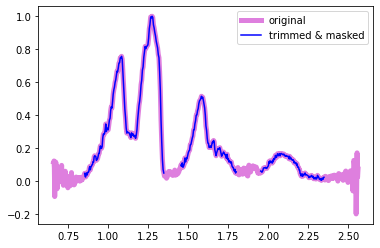

In [12]:
# mask the telluric regions in a ground-based spectrum

# read in spectrum from SPLAT - a noisy T5
sp = splat.getSpectrum(lucky=True, spt='T5',snr=10)[0]

# mask telluric regions and trim off noisy parts
spt = copy.deepcopy(sp)
spt.trim([0.85,2.35])
spt.maskWave([1.35,1.45])
spt.maskWave([1.8,1.95])

# compare
plt.plot(sp.wave,sp.flux,'m-',lw=5,alpha=0.5,label='original')
plt.plot(spt.wave,spt.flux,'b-',label='trimmed & masked')
plt.legend()


## Conducting a grid fit

The simplest fit is comparing a spectrum to all of the models using ``fitGrid()``. The key steps are:

* read in your model grid with ``getModelSet()``
* read in data and make any adjustments you feel are needed
* map the observed spectrum to the model grid wavelength scale using ``resample()``
* run ``fitGrid()``

``fitGrid()`` creates two files for examining your fit:
* PREFIX_compare.pdf - compares data to current best fit model
* PREFIX_parameters.xlsx - parameters for all the chains and the chi^2 and scale values 


In [ ]:
# Example with SpeX prism spectrum from SPLAT
models,wave = ucdmcmc.getModelSet('btsettl08','SPEX-PRISM')

# read in spectrum from SPLAT - a random T5
sp = splat.getSpectrum(lucky=True, spt='T5')[0]
sp.info()

# trim spectrum
sp.trim([0.9,2.35])

# map spectrum to grid models
spsm = ucdmcmc.resample(sp,wave)

# run gridfit - plots are saved to 'test_*.pdf'
par = ucdmcmc.fitGrid(spsm,models,output_prefix='test')

# redisplay comparison if you want to make a better plot
mdl = ucdmcmc.getGridModel(models,par,wave)
mdl.scale(par['scale'])
plt.plot(wave,mdl.flux,'m-',lw=5,alpha=0.5)
plt.plot(wave,spsm.flux,'k-')



returning 1 file


SPEX-PRISM spectrum of 2MASS J05591914-1404488
Airmass = nan
Source designation = J05591914-1404488
Median S/N = 45
SpeX Classification = T4.0
Spectrum key = 10166, Source key = 10459

If you use these data, please cite:
	Burgasser, A. J. et al. (2006, Astrophysical Journal, 637, 1067-1093)
	bibcode: 2006ApJ...637.1067B

History:
	SPEX-PRISM spectrum successfully loaded
Best fit model:
	model = sonora21
	co = 1.0
	logg = 5.5
	teff = 1300.0
	z = -0.0
	scale = 4.818522841812933e-20
	chi = 62745.1891478929
	radius = 0.09736110693240012
	dof = 329.0
	reduced chi2 = 190.71486063189332


<Figure size 432x288 with 0 Axes>

<Figure size 576x504 with 0 Axes>

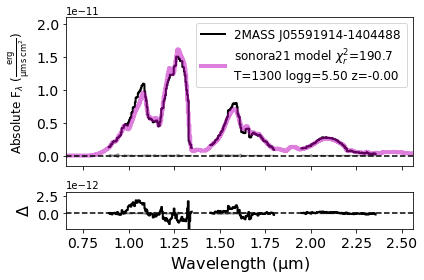

In [15]:
# Using the absolute=True option allows you to also get a fit for the radius
models,wave = ucdmcmc.getModelSet('sonora21','SPEX-PRISM')

# read in T4.5 J0559-1404
sp = splat.getSpectrum(shortname='J0559-1404')[0]
sp.info()

# scale to absolute J magnitude
mj = 13.78 # absolute 2MASS J of this source
sp.fluxCalibrate('2MASS J',mj,absolute=True)

# trim and mask spectrum
sp.trim([0.9,2.35])
sp.maskWave([1.35,1.45])
sp.maskWave([1.8,1.95])

# map spectrum to grid models
spsm = ucdmcmc.resample(sp,wave)

# run gridfit with absolute=True
par = ucdmcmc.fitGrid(spsm,models,output_prefix='test',absolute=True)



In [ ]:
# Example with JWST spectrum
models,wave = ucdmcmc.getModelSet('btsettl08','JWST-NIRSPEC-PRISM')

# read in spectrum from online location from Burgasser et al. 2023
image_file = download_file('https://splat.physics.ucsd.edu/downloads/share/jwst/uncover33437_jwstnirspec.fits', cache=True )
hdu = fits.open(image_file)
data = hdu[1].data
hdu.close()
sp = splat.Spectrum(wave=[x[0] for x in data]*u.micron,flux=[x[1] for x in data]*u.Jy,noise=[x[2] for x in data]*u.Jy)
sp.toFlam()

# trim spectrum
sp.trim([0.95,5])

# map spectrum to grid models
spsm = ucdmcmc.resample(sp,wave,method='median')

# run gridfit
par = ucdmcmc.fitGrid(spsm,models,output_prefix='test')


## Conducting an MCMC fit

MCMC fits can be used after the grid fit to refine the solution and infer the uncertainties in the parameters

* read in your model grid with ``getModelSet()``
* read in data and make any adjustments you feel are needed
* map the observed spectrum to the model grid wavelength scale using ``resample()``
* run ``fitGrid()`` to get the initial parameter guesses
* run ``fitMCMC()`` to get the best fit and parameter uncertainties

``fitMCMC()`` creates four files for examining your fits that are continuously updated during the MCMC run:
* PREFIX_compare.pdf - compares data to current best fit model
* PREFIX_chains.pdf - shows the variation in parameters as the chain progresses
* PREFIX_corner.pdf - corner plot showing those parameters that are varying 
* PREFIX_parameters.xlsx - parameters for all the chains and the chi^2 and scale values 


In [ ]:
# Example with SpeX prism spectrum from SPLAT
models,wave = ucdmcmc.getModelSet('sonora21','SPEX-PRISM')

# read in spectrum from SPLAT - a random T5
sp = splat.getSpectrum(lucky=True, spt='T5')[0]
sp.info()

# map spectrum to grid models
spsm = ucdmcmc.resample(sp,wave)

# get initial parameters from gridfit
ipar = ucdmcmc.fitGrid(spsm,models,output_prefix='test')

# run gridfit
par = ucdmcmc.fitMCMC(spsm,models,p0=ipar,nstep=1000,output_prefix='mcmctest_',verbose=False)


In [ ]:
# Example with JWST NIRSPEC spectrum
models,wave = ucdmcmc.getModelSet('elfowl24','JWST-NIRSPEC-PRISM')

# read in spectrum from online location from Burgasser et al. 2023
image_file = download_file('https://splat.physics.ucsd.edu/downloads/share/jwst/uncover33437_jwstnirspec.fits', cache=True )
hdu = fits.open(image_file)
data = hdu[1].data
hdu.close()
sp = splat.Spectrum(wave=[x[0] for x in data]*u.micron,flux=[x[1] for x in data]*u.Jy,noise=[x[2] for x in data]*u.Jy)
sp.toFlam()

# trim the spectrum
sp.trim([0.95,5])

# map spectrum to grid models
spsm = ucdmcmc.resample(sp,wave)

# get initial parameters from gridfit
ipar = ucdmcmc.fitGrid(spsm,models,output_prefix='initialfit_')

# run gridfit
par = ucdmcmc.fitMCMC(spsm,models,p0=ipar,nstep=1000,output_prefix='mcmcfit_',verbose=False)


## Generating model grids

Generally, if you are fitting a spectrum that is a different format than the instruments provided, or using a new model, you need to generate a new model grid. This can only be done if you have access to the original RAW models in your SPLAT model folder(s) 

In [ ]:
# read in the wavelength grid you are using
wave = ucdmcmc.readWave('JWST-NIRSPEC-PRISM')

# it is helpful to add constraints to your models, as some model sets are quite large (e.g., elfowl24)
constraints = {'teff':[600,3000],'logg':[4.5,6.0],'z':[-0.5,0.5],'co':[0.5,1.5],'enrich':[-0.25,0.25]}

# now run generateModelSet() providing the model name for which you have RAW models accessible to SPLAT
ucdmcmc.generateModelSet('btdusty16',wave=wave,constraints=constraints,output_prefix='models_btdusty16_JWST-NIRSPEC-PRISM',verbose=True,smooth=3,save_wave=False)

# when you're finished, check the grid
grid = ucdmcmc.readModelSet('models_btdusty16_JWST-NIRSPEC-PRISM.h5')
teffs = list(set(list(grid['teff'])))
teffs.sort()
for t in teffs:
    plt.clf()
    gs = grid[grid['teff']==t]
    for i in range(len(gs)): plt.plot(wave,gs['flux'].iloc[i])
    plt.title('Teff = {:.0f}'.format(t))
    plt.show()